# Code to evaluate momentum budgets in NeverWorld2

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['mathtext.fontset'] = "cm"
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean

In [2]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)
    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

The momentum equation for layer $k$ is given by

\begin{align}
    \frac{\partial \mathbf{u}_k}{\partial t} + \left(\frac{{f} + {\zeta}_k}{h_k} \right) \hat{\mathbf{k}} \times (\mathbf{u}_k h_k) + \nabla K_k = - \sum_{i=1}^{k} g_{i-1/2}^\prime \nabla \eta_{i-1/2} + F_{hor} + F_{vert}
    \; 
    \label{eqn:u} \;,
\end{align}

where $\mathbf{u}$ is the horizontal velocity, $h$ is the layer thickness, and $\eta$ is the height of the upper surface of the layer relative to the reference height. $\zeta_k\hat{\mathbf{k}} \equiv \nabla \times \mathbf{u}_k$ and $K_k = \left(\mathbf{u}_k \cdot \mathbf{u}_k \right)/2$. $F_{hor}$ and $F_{vert}$ are the horizontal and vertical friction terms.

In [10]:
tau = 500*86400 # seconds
end_time = 31000
start_time = end_time - tau/86400
run = 20

In [11]:
%pwd

'/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis'

In [14]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/run20
%ls

/glade/p/univ/unyu0004/neerajab/NeverWorld2/run20
A001_21_July_2020_EKE.ipynb
A001_27_July_2020_coarsening_copy.ipynb
A001_27_July_2020_coarsening.ipynb
A002_02_August_2020_EKE.ipynb
A004_28_August_2020_netcdf_to_zarr.ipynb
available_diags.000000
averages_00030002.nc
CPU_stats
diag_table
exitcode
forcing_00000500.nc
forcing_00002500.nc
forcing_00004500.nc
forcing_00006500.nc
forcing_00008500.nc
forcing_00010500.nc
forcing_00012500.nc
forcing_00014500.nc
forcing_00016500.nc
forcing_00018500.nc
forcing_00020500.nc
forcing_00022500.nc
forcing_00024500.nc
forcing_00026500.nc
forcing_00028500.nc
forcing_00030500.nc
INPUT/
input.nml
logfile.000000.out
MOM_IC.nc
MOM_input
MOM_layout
MOM_override
MOM_parameter_doc.all
MOM_parameter_doc.debugging
MOM_parameter_doc.layout
MOM_parameter_doc.short
neeraja_1_4_degree_25000_days.o4049859
neeraja_1_4_degree_25000_days.o4054209
neeraja_1_4_degree_25000_days.o4063510
neeraja_1_4_degree_25000_days.o4355716
neeraja_1_4_degree_25000_days.o4373650
neeraja_

In [16]:
%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
# try:
#     s0 = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, start_time-500+5), decode_times=False)
# except:
#     s0 = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False)
    
# s1 = xr.open_dataset('run%i/snapshots_000%i.nc' % (run, end_time-500+5), decode_times=False)
# av = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
# st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)
av = xr.open_dataset('run%i/averages_00030002.nc' % (run), decode_times=False)
st = xr.open_dataset('run%i/static.nc' % run, decode_times=False)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [17]:
xh = st.xh.values
yh = st.yh.values
xq = st.xq.values
yq = st.yq.values

In [18]:
av

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.049e+04 3.05e+04
  * nv          (nv) float64 1.0 2.0
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e2          (time, zi, yh, xh) float32 ...
    uh          (time, zl, yh, xq) float32 ...
    vh          (time, zl, yq, xh) float32 ...
    PV          (time, zl, yq, xq) float32 ...
    dudt        (time, zl, yh, xq) float32 ...
    dvdt        (time, zl, yq, xh) float32 ...
    CAu         (time, zl, yh, xq) float32 ...
    CAv         (time, zl, yq, xh) float32 ...
    PFu         (time, zl, yh, xq) float32 ...
    PFv         (time, zl, yq, xh) float32 ...
    diffu       (time, zl, yh, xq) float32 ...
    diffv       (time, zl, yq, xh) float32 ...
    du_dt_visc  (time, zl, yh, xq) float32 ...
    dv_dt_visc  (time, zl, yq, xh) float32 ...
    u_BT_accel  (time, zl, yh, xq) float32 ...
    v_BT_accel  (time, zl, yq, xh) float32 ...
    KE          (time, zl, yh, xh) float32 ...
    dKE_dt      (time, zl, yh, xh) float32 ...
    PE_to_KE    (time, zl, yh, xh) float32 ...
    KE_BT       (time, zl, yh, xh) float32 ...
    KE_CorAdv   (time, zl, yh, xh) float32 ...
    KE_adv      (time, zl, yh, xh) float32 ...
    KE_visc     (time, zl, yh, xh) float32 ...
    KE_horvisc  (time, zl, yh, xh) float32 ...
    Rd_dx       (time, yh, xh) float32 ...
    Rd1         (time, yh, xh) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          averages_00030002.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [8]:
#st


AttributeError: 'Dataset' object has no attribute 'taux'

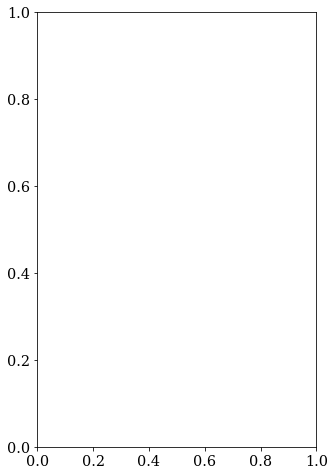

In [19]:
plt.figure(figsize=(23,8))
plt.subplot(1,4,1)
plt.pcolormesh(xq,yh,av.taux.astype(float).values[-1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-0.1,vmax=0.2)
plt.title('Zonal surface stress (atm/ice) [Pa]'); 
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
#
plt.subplot(1,4,2)
plt.pcolormesh(xq,yh,av.taux_bot.astype(float).values[-1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-0.1,vmax=0.2)
plt.title('Zonal bottom stress (ocean to Earth) [Pa]');
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
#
plt.subplot(1,4,3)
plt.pcolormesh(xh,yq,av.tauy.astype(float).values[-1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-0.1,vmax=0.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Meridional surface stress (atm/ice) [Pa]');
plt.colorbar()
#
plt.subplot(1,4,4)
plt.pcolormesh(xh,yq,av.tauy_bot.astype(float).values[-1],norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-0.1,vmax=0.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Meridional bottom stress (ocean to Earth) [Pa]');
plt.colorbar()





In [30]:
layer_no = 6

term1_u = av.dudt.astype(float).values[-1,layer_no]
term2_u = av.CAu.astype(float).values[-1,layer_no]
term3_u = av.PFu.astype(float).values[-1,layer_no]
term4_u = av.diffu.astype(float).values[-1,layer_no]
term5_u = av.du_dt_visc.astype(float).values[-1,layer_no] #- av.taux.astype(float).values[-1] - av.taux_bot.astype(float).values[-1]

M_u = term1_u - term2_u - term3_u - term4_u - term5_u

term1_v = av.dvdt.astype(float).values[-1,layer_no]
term2_v = av.CAv.astype(float).values[-1,layer_no]
term3_v = av.PFv.astype(float).values[-1,layer_no]
term4_v = av.diffv.astype(float).values[-1,layer_no]
term5_v = av.dv_dt_visc.astype(float).values[-1,layer_no] #- av.tauy.astype(float).values[-1] - av.tauy_bot.astype(float).values[-1]

M_v = term1_v - term2_v - term3_v - term4_v - term5_v




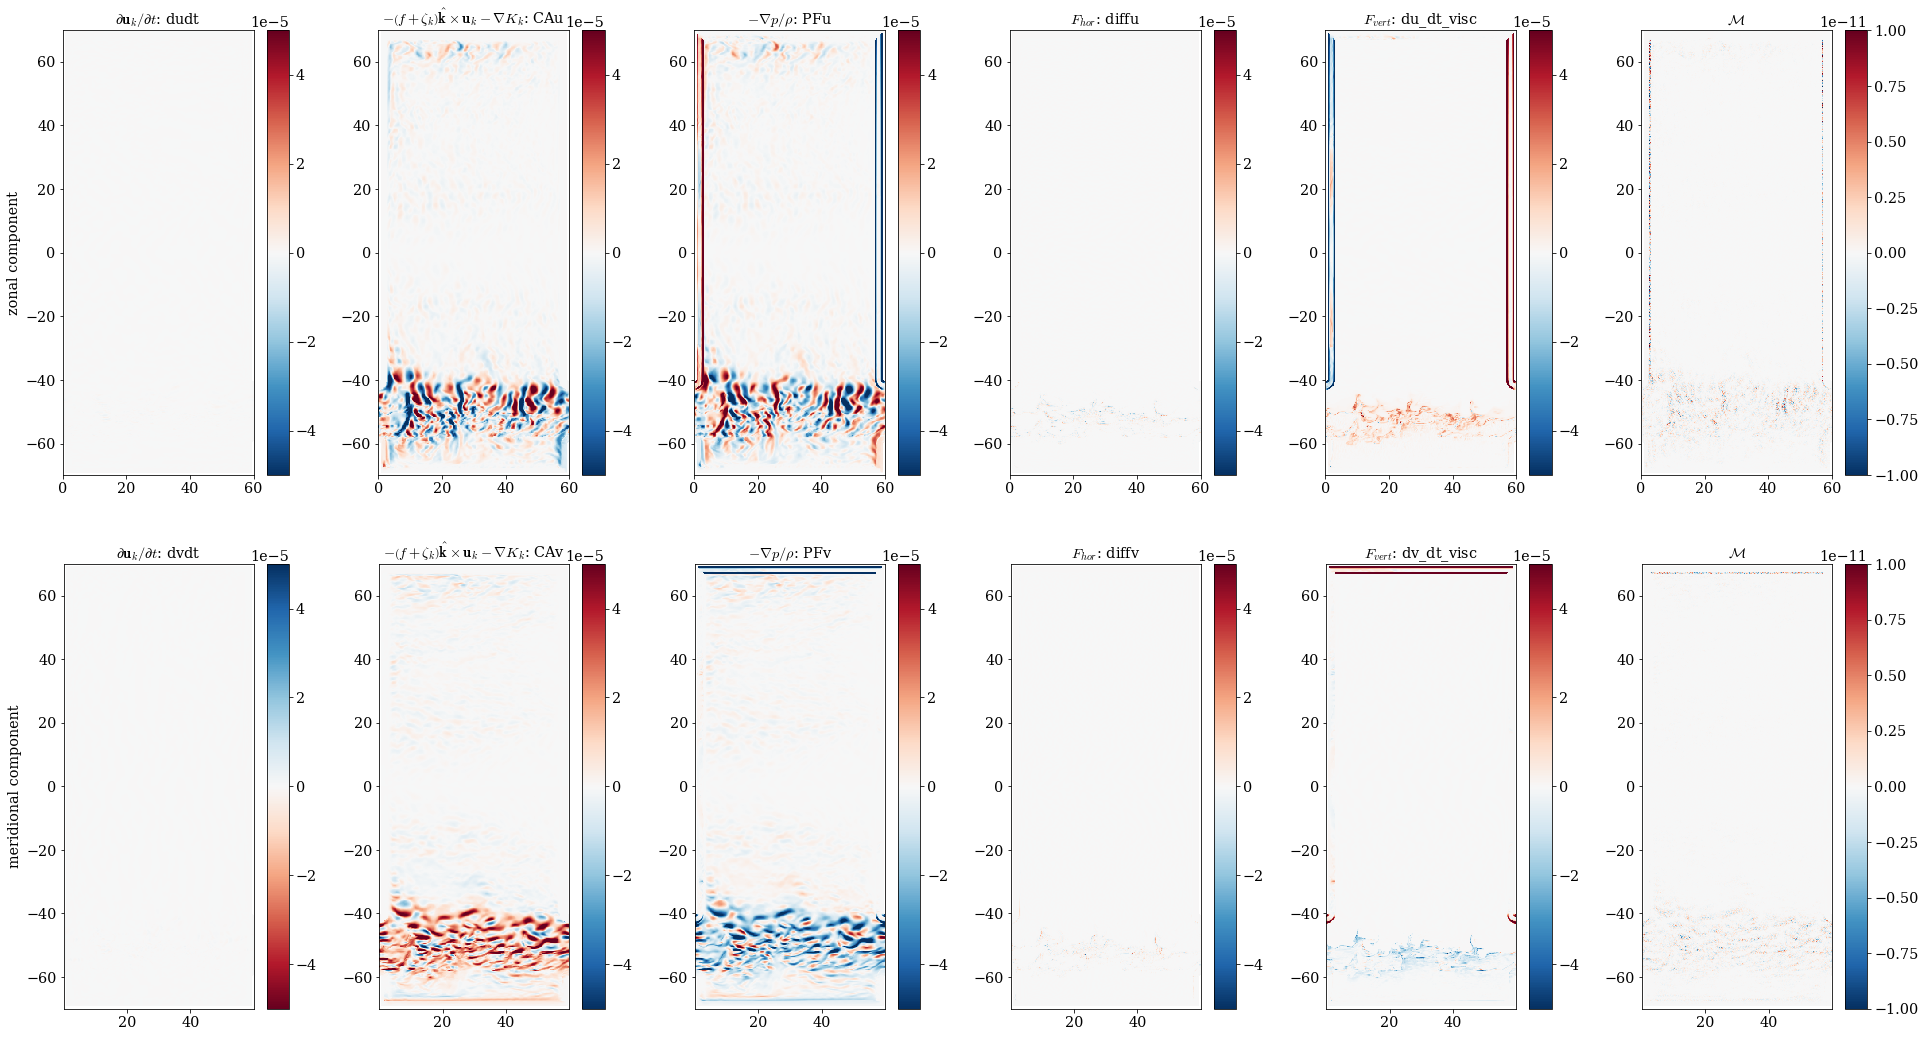

In [31]:
plt.figure(figsize=(33,18))
limlow=-.5e-4; limhigh=.5e-4;
plt.subplot(2,6,1)
plt.pcolormesh(xq,yh,term1_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel('zonal component')
plt.title(r'$\partial \mathbf{u}_k /\partial t$: dudt')
plt.colorbar()

plt.subplot(2,6,2)
plt.pcolormesh(xq,yh,term2_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$- \left({f} + {\zeta}_k \right) \hat{\mathbf{k}} \times \mathbf{u}_k - \nabla K_k$: CAu')
plt.colorbar()

plt.subplot(2,6,3)
plt.pcolormesh(xq,yh,term3_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$-\nabla p/\rho$: PFu')
plt.colorbar()

plt.subplot(2,6,4)
plt.pcolormesh(xq,yh,term4_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{hor}$: diffu')
plt.colorbar()

plt.subplot(2,6,5)
plt.pcolormesh(xq,yh,term5_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{vert}$: du_dt_visc')
plt.colorbar()

plt.subplot(2,6,6)
plt.pcolormesh(xq,yh,M_u,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-1e-11,vmax=1e-11)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{M}$')
plt.colorbar()

plt.subplot(2,6,7)
plt.pcolormesh(xh,yq,term1_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial \mathbf{u}_k /\partial t$: dvdt')
plt.ylabel('meridional component')
plt.colorbar()

plt.subplot(2,6,8)
plt.pcolormesh(xh,yq,term2_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$- \left({f} + {\zeta}_k \right) \hat{\mathbf{k}} \times \mathbf{u}_k - \nabla K_k$: CAv')
plt.colorbar()

plt.subplot(2,6,9)
plt.pcolormesh(xh,yq,term3_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.title(r'$-\nabla p/\rho$: PFv')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.subplot(2,6,10)
plt.pcolormesh(xh,yq,term4_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{hor}$: diffv')
plt.colorbar()

plt.subplot(2,6,11)
plt.pcolormesh(xh,yq,term5_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=limlow,vmax=limhigh)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$F_{vert}$: dv_dt_visc')
plt.colorbar()

plt.subplot(2,6,12)
plt.pcolormesh(xh,yq,M_v,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-1e-11,vmax=1e-11)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\mathcal{M}$')
plt.colorbar()

plt.savefig('Momentum_end_time_%i_days_tau_5_days_layer_%i.png' % (end_time,layer_no), dpi=200,bbox_inches='tight',pad_inches=0)

In [33]:
tau = 500*86400 # seconds
end_time = 31500
start_time = end_time - tau/86400
run = 18

%cd /glade/p/univ/unyu0004/neerajab/NeverWorld2/
lm = xr.open_dataset('run%i/averages_000%i.nc' % (run, end_time-500+2), decode_times=False)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis



/glade/p/univ/unyu0004/neerajab/NeverWorld2
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [34]:
lm

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, yh: 560, zl: 15)
Coordinates:
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3.1e+04 3.101e+04 ... 3.149e+04 3.15e+04
  * nv          (nv) float64 1.0 2.0
Data variables:
    KE          (time, zl, yh, xh) float32 ...
    dKE_dt      (time, zl, yh, xh) float32 ...
    PE_to_KE    (time, zl, yh, xh) float32 ...
    KE_CorAdv   (time, zl, yh, xh) float32 ...
    KE_adv      (time, zl, yh, xh) float32 ...
    KE_visc     (time, zl, yh, xh) float32 ...
    KE_horvisc  (time, zl, yh, xh) float32 ...
    average_T1  (time) float64 ...
    average_T2  (time) float64 ...
    average_DT  (time) float64 ...
    time_bnds   (time, nv) float64 ...
Attributes:
    filename:          averages_00031002.nc
    title:             NeverWorld2
    associated_files:  area_t: static.nc
    grid_type:         regular
    grid_tile:         N/A

In [20]:
layer_no=0

term1_E = lm.dKE_dt.astype(float).values[-1,layer_no]
term2_E = lm.PE_to_KE.astype(float).values[-1,layer_no]
term3_E = lm.KE_CorAdv.astype(float).values[-1,layer_no]
# term4_E = lm.KE_adv.astype(float).values[-1,layer_no]  
term5_E = lm.KE_visc.astype(float).values[-1,layer_no]
term6_E = lm.KE_horvisc.astype(float).values[-1,layer_no]

E = term1_E  - (term2_E + term3_E + term5_E + term6_E)

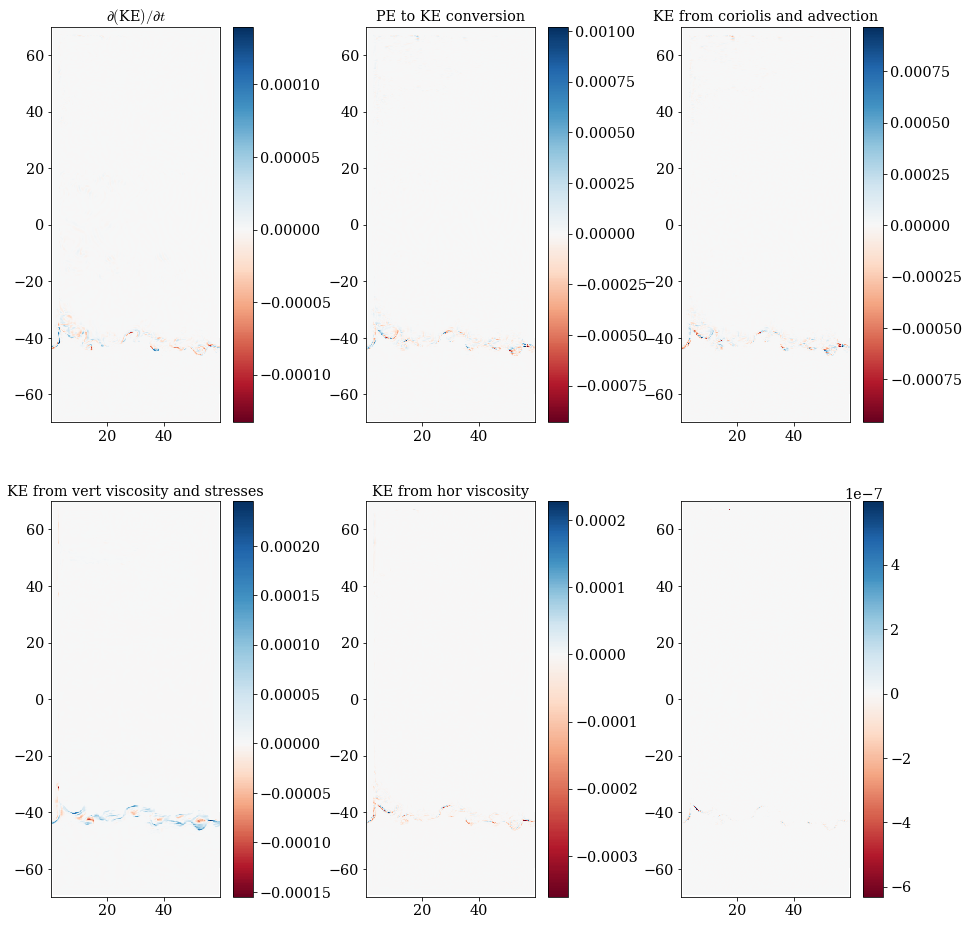

In [21]:
plt.figure(figsize=(16,16))

plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,term1_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,term2_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'PE to KE conversion')
plt.colorbar()

plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,term3_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from coriolis and advection')
plt.colorbar()

plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,term5_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity and stresses')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,term6_E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

plt.savefig('KE_end_time_%i_days_tau_%i_days_layer_%i.png' % (end_time,tau/86400,layer_no), dpi=200,bbox_inches='tight',pad_inches=0)